In [1]:
# https://github.com/MhLiao/DB
# https://github.com/zonasw/DBNet
# https://github.com/WenmuZhou/DBNet.pytorch
# https://github.com/xuannianz/DifferentiableBinarization
# https://github.com/18520339/dbnet-tf2
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    device_name = tf.test.gpu_device_name()
    print('Found GPU at:', device_name)
    !nvcc -V
else: print('Using CPU')

Using CPU


# Hyperparameters

In [3]:
IGNORE_TEXTS = ['###']
IMAGE_SIZE = 640 # Must be divisible by 32
THRESH_MIN = 0.3
THRESH_MAX = 0.7
SHRINK_RATIO = 0.4

MIN_BOX_SCORE = 0.5
MAX_CANDIDATES = 1000
IMAGE_SHORT_SIDE = 736 # Must be divisible by 32
AREA_PRECISION_CONSTRAINT = 0.4
AREA_RECALL_CONSTRAINT = 0.4

In [4]:
TRAIN_PATHS_MAP = './datasets/train.txt'
VALIDATE_PATHS_MAP = './datasets/validate.txt'
TRAIN_BATCH_SIZE = 64
VALIDATE_BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 2

# Load the data

In [5]:
from tfdbnet.loader import AnnotationsImporter, DataGenerator
train_annotations = AnnotationsImporter(TRAIN_PATHS_MAP)
validate_annotations = AnnotationsImporter(VALIDATE_PATHS_MAP)

[GET] Loading from ./datasets/train.txt: 993 images
[GET] Loading from ./datasets/validate.txt: 500 images


In [6]:
print(
    f'Number of images found:'
    f' {train_annotations.images_count} + {validate_annotations.images_count} ='
    f' {train_annotations.images_count + validate_annotations.images_count}\n'
    f'Number of bounding boxes in all images:'
    f' {train_annotations.all_boxes_count} + {validate_annotations.all_boxes_count} ='
    f' {train_annotations.all_boxes_count + validate_annotations.all_boxes_count}'
)

Number of images found: 993 + 500 = 1493
Number of bounding boxes in all images: 10354 + 5688 = 16042


In [7]:
train_generator = DataGenerator(
    train_annotations.annotations, 
    TRAIN_BATCH_SIZE, IMAGE_SIZE, IGNORE_TEXTS,  
    THRESH_MIN, THRESH_MAX, SHRINK_RATIO, seed=2022
)
validate_generator = DataGenerator(
    validate_annotations.annotations, 
    VALIDATE_BATCH_SIZE, IMAGE_SIZE, IGNORE_TEXTS, 
    THRESH_MIN, THRESH_MAX, SHRINK_RATIO, seed=None # No shuffle
)

# Build and compile the model

In [8]:
from tfdbnet.model import DBNet
from tfdbnet.processor import PostProcessor
post_processor = PostProcessor(min_box_score=MIN_BOX_SCORE, max_candidates=MAX_CANDIDATES)
dbnet = DBNet(post_processor, backbone='ResNet18', k=50)

In [9]:
from tensorflow.keras.optimizers import Adam
from tfdbnet.losses import DBLoss
dbnet.compile(
    optimizer = Adam(learning_rate=LEARNING_RATE, amsgrad=True), 
    loss = DBLoss(alpha=5.0, beta=10.0, negative_ratio=3.0)
)
dbnet.model.summary(line_length=120)

Model: "DBNet"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image (InputLayer)                    [(None, None, None, 3)]    0             []                                      
                                                                                                                        
 conv1 (Conv2D)                        (None, None, None, 64)     9408          ['image[0][0]']                         
                                                                                                                        
 bn_conv1 (BatchNormalization)         (None, None, None, 64)     256           ['conv1[0][0]']                         
                                                                                                                        
 conv1_relu (Acti

                                                                                                                        
 bn3a_branch2b (BatchNormalization)    (None, None, None, 128)    512           ['res3a_branch2b[0][0]']                
                                                                                                                        
 bn3a_branch1 (BatchNormalization)     (None, None, None, 128)    512           ['res3a_branch1[0][0]']                 
                                                                                                                        
 res3a (Add)                           (None, None, None, 128)    0             ['bn3a_branch2b[0][0]',                 
                                                                                 'bn3a_branch1[0][0]']                  
                                                                                                                        
 res3a_relu (Activation)        

                                                                                                                        
 res4b1_relu (Activation)              (None, None, None, 256)    0             ['res4b1[0][0]']                        
                                                                                                                        
 padding5a_branch2a (ZeroPadding2D)    (None, None, None, 256)    0             ['res4b1_relu[0][0]']                   
                                                                                                                        
 res5a_branch2a (Conv2D)               (None, None, None, 512)    1179648       ['padding5a_branch2a[0][0]']            
                                                                                                                        
 bn5a_branch2a (BatchNormalization)    (None, None, None, 512)    2048          ['res5a_branch2a[0][0]']                
                                

 P2 (ConvBnRelu)                       (None, None, None, 64)     147776        ['tf.__operators__.add_2[0][0]']        
                                                                                                                        
 P3 (Sequential)                       (None, None, None, 64)     147776        ['tf.__operators__.add_1[0][0]']        
                                                                                                                        
 P4 (Sequential)                       (None, None, None, 64)     147776        ['tf.__operators__.add[0][0]']          
                                                                                                                        
 P5 (Sequential)                       (None, None, None, 64)     147776        ['in5[0][0]']                           
                                                                                                                        
 fuse (Concatenate)             

In [11]:
from keras import Model
import numpy as np
import os
import cv2

for i in range(len(dbnet.model.layers)):
    layer  = dbnet.model.layers[i]
    print(i, layer.name, layer.output.shape)

0 image (None, None, None, 3)
1 conv1 (None, None, None, 64)
2 bn_conv1 (None, None, None, 64)
3 conv1_relu (None, None, None, 64)
4 pool1 (None, None, None, 64)
5 padding2a_branch2a (None, None, None, 64)
6 res2a_branch2a (None, None, None, 64)
7 bn2a_branch2a (None, None, None, 64)
8 res2a_branch2a_relu (None, None, None, 64)
9 padding2a_branch2b (None, None, None, 64)
10 res2a_branch2b (None, None, None, 64)
11 res2a_branch1 (None, None, None, 64)
12 bn2a_branch2b (None, None, None, 64)
13 bn2a_branch1 (None, None, None, 64)
14 res2a (None, None, None, 64)
15 res2a_relu (None, None, None, 64)
16 padding2b1_branch2a (None, None, None, 64)
17 res2b1_branch2a (None, None, None, 64)
18 bn2b1_branch2a (None, None, None, 64)
19 res2b1_branch2a_relu (None, None, None, 64)
20 padding2b1_branch2b (None, None, None, 64)
21 res2b1_branch2b (None, None, None, 64)
22 bn2b1_branch2b (None, None, None, 64)
23 res2b1 (None, None, None, 64)
24 res2b1_relu (None, None, None, 64)
25 padding3a_branch2a

# Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tfdbnet.metrics import TedEvalMetric
from tqdm.notebook import tqdm

# Stop if no improvement after 10 epochs
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

# Calculate TedEvalMetric after 10 epochs
tedeval_callback = TedEvalMetric(
    true_annotations = validate_annotations.annotations, 
    ignore_texts = IGNORE_TEXTS, 
    min_box_score = MIN_BOX_SCORE,
    image_short_side = IMAGE_SHORT_SIDE,
    area_precision_constraint = AREA_PRECISION_CONSTRAINT,
    area_recall_constraint = AREA_RECALL_CONSTRAINT,
    progressbar = tqdm,
    eval_best_weights = True, # Restore the best model and evaluate it on train end 
    eval_steps = 10,
)

# Training

In [ ]:
%%time
history = dbnet.fit(
    train_generator,
    validation_data = validate_generator,
    validation_steps = len(validate_generator),
    steps_per_epoch = len(train_generator),
    epochs = EPOCHS,
    callbacks = [early_stopping_callback, tedeval_callback],
    verbose = 1
).history
dbnet.model.save_weights('dbnet.h5')

# Inference

In [84]:
import cv2
from tfdbnet.utils import resize_image_short_side, draw_predictions
raw_image = cv2.cvtColor(cv2.imread('IMG_0489.JPG'), cv2.COLOR_BGR2RGB)
image = resize_image_short_side(raw_image, image_short_side=IMAGE_SHORT_SIDE)
image = image.astype(float) / 255.0

In [85]:
dbnet.model.load_weights('dbnet.h5')

In [66]:
from keras.utils.vis_utils import plot_model

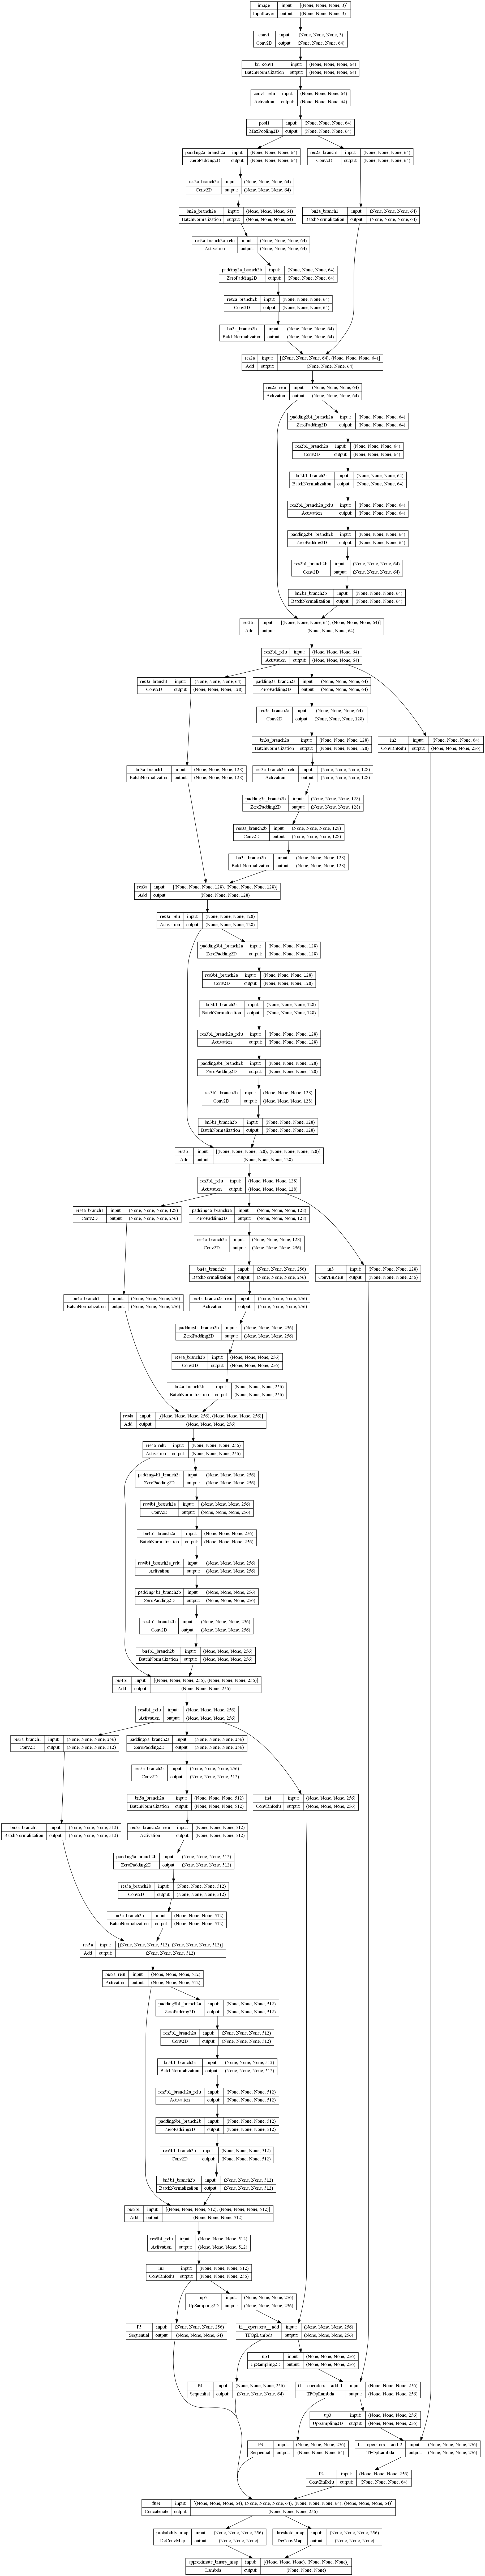

In [24]:
plot_model(dbnet.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

[[array([[[101, 692]],

       [[566, 699]],

       [[565, 741]],

       [[100, 733]]]), -0.016258729805101572], [array([[[606, 700]],

       [[970, 701]],

       [[969, 741]],

       [[605, 739]]]), -0.00450447403852987], [array([[[1272,  707]],

       [[1444,  709]],

       [[1443,  748]],

       [[1271,  746]]]), -0.00909065866449625], [array([[[ 995,  708]],

       [[1185,  708]],

       [[1185,  743]],

       [[ 995,  743]]]), -0.0], [array([[[406, 782]],

       [[625, 786]],

       [[624, 808]],

       [[405, 805]]]), -0.01503646065849529], [array([[[310, 784]],

       [[408, 784]],

       [[408, 805]],

       [[310, 805]]]), -0.0], [array([[[256, 784]],

       [[317, 784]],

       [[317, 805]],

       [[256, 805]]]), -0.0], [array([[[618, 789]],

       [[787, 789]],

       [[787, 810]],

       [[618, 810]]]), -0.0], [array([[[1371,  791]],

       [[1519,  791]],

       [[1519,  815]],

       [[1371,  815]]]), -0.0], [array([[[ 883,  791]],

       [[109

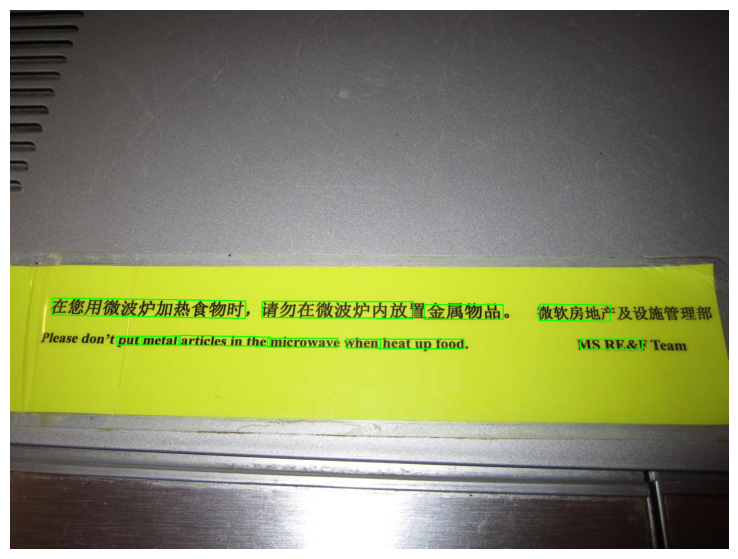

In [86]:
batch_boxes, batch_scores = dbnet.predict(
    batch_images = tf.expand_dims(image, 0), 
    batch_true_sizes = [raw_image.shape[:2]], 
    output_polygon = True
)

image, outputs = draw_predictions(raw_image, batch_boxes[0], batch_scores[0])
print(outputs)

In [87]:
# https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python
import numpy as np
import cv2

img = raw_image.copy()
pts , ang = outputs[0]

rect = cv2.minAreaRect(pts)
angle = rect[-1] - 90
angle = 90 + angle if angle < - 45 else angle
print(angle)

## (1) Crop the bounding rect
rect = cv2.boundingRect(pts)
x,y,w,h = rect
croped = img[y:y+h, x:x+w].copy()

## (2) make mask
pts = pts - pts.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)

## (4) add the white background
bg = np.ones_like(croped, np.uint8)*255
cv2.bitwise_not(bg,bg, mask=mask)
dst2 = bg+ dst


cv2.imwrite("croped.png", croped)
cv2.imwrite("mask.png", mask)
cv2.imwrite("dst.png", dst)
cv2.imwrite("dst2.png", dst2)

0.9856365323066711


True

In [88]:
rot_img = dst2.copy()
(h,w) = rot_img.shape[:2]
center = (w // 2, h // 2 )

m = cv2.getRotationMatrix2D(center, angle , 1.0)
rot_img = cv2.warpAffine(rot_img, m, (w, h), flags = cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
cv2.imwrite("skewCorrect.png", rot_img)

True